In [83]:
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import fitsio
import desimodel.io
import desitarget.mtl
import desisim.quickcat
from astropy.io import fits
from astropy.table import Table, Column, vstack
import json


from time import asctime

from desitarget.targetmask import desi_mask, obsconditions
from collections import Counter
import subprocess
from desiutil.log import get_logger
log = get_logger()
%matplotlib inline

In [3]:
mtl_file = "targets/dr8_mtl_dark_gray_northern_cap.fits"
mtl_data = Table.read(mtl_file)

In [4]:
print(len(mtl_data))
r = np.random.random(len(mtl_data))
rr = r<0.0001

61201562


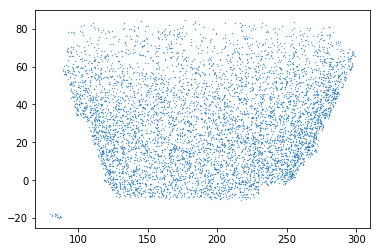

In [5]:
plt.scatter(mtl_data['RA'][rr], mtl_data['DEC'][rr], s=0.1)

# Create a smaller mtl file

In [2]:
new_mtl_file = "targets/subset_dr8_mtl_dark_gray_northern_cap.fits"
if not os.path.exists(new_mtl_file):
    subset_ii = (mtl_data['RA']>145) & (mtl_data['RA']<205)
    subset_ii &= (mtl_data['DEC']>-5) & (mtl_data['DEC']<25)
    mtl_data[subset_ii].write(new_mtl_file, overwrite=True)

In [3]:
targets = Table.read(new_mtl_file)

In [4]:
sky_file = "targets/subset_dr8_sky.fits"
if not os.path.exists(sky_file):
    sky_data = Table.read("/project/projectdirs/desi/target/catalogs/dr8/0.31.0/skies/skies-dr8-0.31.0.fits")
    subset_ii = (sky_data['RA']>145) & (sky_data['RA']<205)
    subset_ii &= (sky_data['DEC']>-5) & (sky_data['DEC']<25)
    print('writing sky')
    sky_data[subset_ii].write(sky_file, overwrite=True)
    print('done writing sky')

# Build the corresponding truth catalog

In [5]:
#truth file
truthfile = "targets/subset_truth_dr8_mtl_dark_gray_northern_cap.fits"
if not os.path.exists(truthfile):
    import desitarget.mock.mockmaker as mb
    from desitarget.targetmask import desi_mask, bgs_mask, mws_mask

    #targetsfilename = "small_chunk_targets-dr5.0-0.16.2.fits"
    #targets = fitsio.read(targetfile, 'TARGETS', columns=columns)
    colnames = list(targets.dtype.names)
    print(colnames)
    nobj = len(targets)
    truth = mb.empty_truth_table(nobj=nobj)[0]
    print(truth.keys())

    for k in colnames:
        if k in truth.keys():
            print(k)
            truth[k][:] = targets[k][:]

    nothing = '          '
    truth['TEMPLATESUBTYPE'] = np.repeat(nothing, nobj)

    masks = ['ELG', 'LRG', 'QSO', 'MWS_ANY', 'BGS_ANY', 'STD_FAINT', 'STD_BRIGHT']
    dict_truespectype = {'BGS_ANY':'GALAXY', 'ELG':'GALAXY', 'LRG':'GALAXY', 'QSO':'QSO', 
                    'MWS_ANY':'STAR', 'STD_FAINT':'STAR', 'STD_BRIGHT':'STAR'}
    dict_truetemplatetype = {'BGS_ANY':'BGS', 'ELG':'ELG', 'LRG':'LRG', 'QSO':'QSO', 
                        'MWS_ANY':'STAR', 'STD_FAINT':'STAR', 'STD_BRIGHT':'STAR'}

    for m in masks:
        istype = (targets['DESI_TARGET'] & desi_mask.mask(m))!=0
        print(m, np.count_nonzero(istype))
        truth['TRUESPECTYPE'][istype] = np.repeat(dict_truespectype[m], np.count_nonzero(istype))
        truth['TEMPLATETYPE'][istype] = np.repeat(dict_truetemplatetype[m], np.count_nonzero(istype))
        truth['MOCKID'][istype] = targets['TARGETID'][istype]

    # Check that all targets have been assigned to a class
    iii = truth['MOCKID']==0
    assert np.count_nonzero(iii)==0
    
    print('writing truth')
    truth.write(truthfile, overwrite=True)
    print('done truth')
truth = Table.read(truthfile)

In [115]:
tiles = Table(desimodel.io.load_tiles())

ii_tiles = tiles['PROGRAM'] != 'BRIGHT'
ii_tiles &= tiles['RA'] > 150 
ii_tiles &= tiles['RA'] < 200
ii_tiles &= tiles['DEC'] > 0
ii_tiles &= tiles['DEC'] < 20

tilefile = 'footprint/subset_dark123_gray.fits'
tiles[ii_tiles].write(tilefile, overwrite='True')
tiles = Table.read(tilefile)

In [124]:
ii_gray = tiles['PROGRAM']=='GRAY'
ii_dark_0 = (tiles['PROGRAM']=='DARK') & (tiles['PASS']==0)
ii_dark_1 = (tiles['PROGRAM']=='DARK') & (tiles['PASS']==1)
ii_dark_2 = (tiles['PROGRAM']=='DARK') & (tiles['PASS']==2)
ii_dark_3 = (tiles['PROGRAM']=='DARK') & (tiles['PASS']==3)

footprint = dict()
footprint['gray'] = tiles[ii_gray]
footprint['dark0'] = tiles[ii_dark_0]
footprint['dark1'] = tiles[ii_dark_1]
footprint['dark2'] = tiles[ii_dark_2]
footprint['dark3'] = tiles[ii_dark_3]

In [128]:
footprint['gray'].write('footprint/subset_gray.fits')
footprint['dark0'].write('footprint/subset_dark0.fits')
footprint['dark1'].write('footprint/subset_dark1.fits')
vstack([footprint['dark2'], footprint['dark3']]).write('footprint/subset_dark2_dark3.fits', overwrite=True)
vstack([footprint['gray'], footprint['dark0'], footprint['dark1'], footprint['dark2'], footprint['dark3']]).write('footprint/subset_gray_dark0_dark1_dark2_dark3.fits', overwrite=True)

In [144]:
pass_names = ['gray', 'dark0', 'dark1', 'dark2_dark3', 'full']
for i_pass in range(3):
    old_pass_name = pass_names[i_pass-1]
    pass_name = pass_names[i_pass]
    new_pass_name = pass_names[i_pass+1]
    
    os.makedirs('fiberassign_'+pass_name, exist_ok=True)
    
    footprint_filename = 'footprint/subset_{}.fits'.format(pass_name)
    fiberassign_dir = 'fiberassign_{}/'.format(pass_name)
    old_mtl_filename = 'targets/{}_subset_dr8_mtl_dark_gray_northern_cap.fits'.format(pass_name)
    new_mtl_filename = 'targets/{}_subset_dr8_mtl_dark_gray_northern_cap.fits'.format(new_pass_name)
    old_zcat_filename = 'zcat/{}_zcat.fits'.format(old_pass_name)
    new_zcat_filename = 'zcat/{}_zcat.fits'.format(pass_name)
    
    # Run fiberassign
    cmd = 'fiberassign --mtl {} --sky targets/subset_dr8_sky.fits '.format(old_mtl_filename)
    cmd +=' --footprint {} --outdir {} --overwrite'.format(footprint_filename, fiberassign_dir)
    print(cmd)
    ! $cmd
    
    # Run qa
    cmd = "fba_run_qa --dir {} --footprint {}".format(fiberassign_dir, footprint_filename)
    print(cmd)
    ! $cmd
    
    # Gather fiberassign files
    fba_files = glob.glob(os.path.join(fiberassign_dir,"tile*.fits"))
    
    # Read targets and truth
    targets = Table.read(old_mtl_filename)
    truth = Table.read(truthfile)
    
    # Compute zcat
    if i_pass==0:
        zcat = desisim.quickcat.quickcat(fba_files, targets, truth, perfect=True)
    else:
        old_zcat = Table.read(old_zcat_filename)
        zcat = desisim.quickcat.quickcat(fba_files, targets, truth, zcat=old_zcat, perfect=True)        
    
    zcat.write(new_zcat_filename, overwrite=True)
    mtl = desitarget.mtl.make_mtl(targets, zcat)
    mtl.write(new_mtl_filename, overwrite=True)
        
    
    

fiberassign --mtl targets/gray_subset_dr8_mtl_dark_gray_northern_cap.fits --sky targets/subset_dr8_sky.fits  --footprint footprint/subset_gray.fits --outdir fiberassign_gray/ --overwrite
INFO: Reading fiber positions from /global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/code/desimodel/master/data/focalplane/fiberpos-all.fits
INFO: Target file targets/gray_subset_dr8_mtl_dark_gray_northern_cap.fits has 8353255 rows.  Reading in chunks of 1000000
INFO: Read target file targets/gray_subset_dr8_mtl_dark_gray_northern_cap.fits:  10.39 seconds (1 calls)
INFO: Target file targets/subset_dr8_sky.fits has 9094451 rows.  Reading in chunks of 1000000
INFO: Read target file targets/subset_dr8_sky.fits:  12.15 seconds (1 calls)
INFO: Building target tree:  4.98 seconds (1 calls)
INFO: Computing targets available to all tile / locations:  14.74 seconds (1 calls)
INFO: Computing tile / locations available to all objects:  11.22 seconds (1 calls)
INFO: Assignment constructor project tar

KeyboardInterrupt: 

In [24]:
#fiberassign --mtl targets/subset_dr8_mtl_dark_gray_northern_cap.fits --sky targets/subset_dr8_sky.fits --footprint footprint/subset_dark123_gray.fits --outdir fiberassign/
#fba_run_qa --dir fiberassign/ --footprint footprint/subset_dark123_gray.fits 

In [141]:
pass_names = ['gray', 'dark0', 'dark1', 'dark2_dark3', 'full']
pass_names[-1]

'full'

In [9]:
fba_output_dir = "./fiberassign"
fba_files = glob.glob(os.path.join(fba_output_dir,"tile*.fits"))

In [10]:
zcat = desisim.quickcat.quickcat(fba_files, targets, truth, perfect=True)

INFO:quickcat.py:585:quickcat: Wed Aug  7 10:05:17 2019 QC Reading 629 tiles
INFO:quickcat.py:629:quickcat: Wed Aug  7 10:06:12 2019 QC Trimming truth to just observed targets
INFO:quickcat.py:636:quickcat: Wed Aug  7 10:06:15 2019 QC Constructing new redshift catalog
INFO:quickcat.py:648:quickcat: Wed Aug  7 10:06:15 2019 QC Adding ZERR and ZWARN
INFO:quickcat.py:666:quickcat: Wed Aug  7 10:06:15 2019 QC Adding NUMOBS column
INFO:quickcat.py:672:quickcat: Wed Aug  7 10:06:30 2019 QC Merging previous zcat
INFO:quickcat.py:712:quickcat: Wed Aug  7 10:06:30 2019 QC done


In [11]:
zcat_file = 'zcat/zcat_subset_dark123_gray.fits'
zcat.write(zcat_file, overwrite=True)

In [12]:
zcat = Table.read(zcat_file)

# Global statistics

In [ ]:
# Using zcat, truth, targets, we are missing one more that is 'available' 


In [20]:
def consolidate_favail(fba_files):
    # getting all the targetids of the assigned fibers
    print('reading the individual fiberassign files')
    favail = list()
    for i_tile, tile_file in enumerate(fba_files):
        if i_tile%20 ==0:
            print(i_tile)
        id_favail, header = fits.getdata(tile_file, 'FAVAIL', header=True)
        favail.extend(id_favail['TARGETID'])
    return list(set(favail))

In [21]:
favail = consolidate_favail(fba_files)

reading the individual fiberassign files
0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
520
540
560
580
600
620


In [30]:
ii_avail = np.in1d(targets['TARGETID'], favail)
targets_avail = targets[ii_avail]

ii_avail = np.in1d(truth['TARGETID'], favail)
truth_avail = truth[ii_avail]

In [34]:
ii_zcat = np.in1d(targets['TARGETID'], zcat['TARGETID'])
targets_zcat = targets[ii_zcat]

assert len(zcat)==len(targets_zcat)
assert len(truth_avail)==len(targets_avail)

In [33]:
print(len(targets), len(targets_avail), len(targets_zcat), len(truth_avail), len(zcat))

8353255 4631070 2246453 4631070 2246453


In [106]:
def global_efficiency(targets, id_avail, zcat, target_class='QSO'):
    ii_avail = np.in1d(targets['TARGETID'], id_avail)
    targets_avail = targets[ii_avail]


    is_class = (targets_avail['DESI_TARGET'] & desi_mask.mask(target_class))!=0
    targets_avail_class = targets_avail[is_class]
    n_avail = len(targets_avail_class)

    is_class_from_zcat = np.in1d(targets_avail_class['TARGETID'], zcat['TARGETID'])
    targets_zcat_class = targets_avail_class[is_class_from_zcat]
    n_assigned = len(targets_zcat_class)

    is_class_in_zcat = np.in1d(zcat['TARGETID'], targets_zcat_class['TARGETID'])
    zcat_class = zcat[is_class_in_zcat]

    nobs = dict()
    for i in range(10):
        nobs[i] = np.count_nonzero(zcat_class['NUMOBS']==i)/n_avail
    nobs[0] = (n_avail - n_assigned)/n_avail

    print(target_class, n_assigned/n_avail, n_avail, n_assigned, nobs)
    
def tile_efficiency(qa_json_file):
    f = open(qa_json_file)
    qa_dict = json.load(f)
    f.close()
    assign_total = []
    assign_science= []
    assign_sky = []
    assign_std = []
    for k in qa_dict:
        assign_total.append(qa_dict[k]['assign_total'])
        assign_science.append(qa_dict[k]['assign_science'])
        assign_sky.append(qa_dict[k]['assign_sky'])
        assign_std.append(qa_dict[k]['assign_std'])
    assign_total = np.array(assign_total)
    assign_science = np.array(assign_science)
    assign_sky = np.array(assign_sky)
    assign_std = np.array(assign_std)
    n_not_enough_sky = np.count_nonzero(assign_sky<400)
    n_not_enough_std = np.count_nonzero(assign_std<100)
    f_unassigned = (5000 - assign_total)/5000
    print(n_not_enough_sky, n_not_enough_std, np.median(f_unassigned))

In [109]:
tile_efficiency('fiberassign/qa.json')
global_efficiency(targets, favail, zcat, target_class='QSO')
global_efficiency(targets, favail, zcat, target_class='LRG')
global_efficiency(targets, favail, zcat, target_class='ELG')
global_efficiency(targets, favail, zcat, target_class='LRG_2PASS')

0 0 0.0
QSO 0.9757944576061814 285761 278844 {0: 0.02420554239381861, 1: 0.16808451818127737, 2: 0.15990285588306313, 3: 0.23581244466529722, 4: 0.4119281497475163, 5: 5.599084549676128e-05, 6: 6.99885568709516e-06, 7: 3.49942784354758e-06, 8: 0.0, 9: 0.0}
LRG 0.8278671736931785 473611 392087 {0: 0.17213282630682142, 1: 0.6527698892128773, 2: 0.1750360527943819, 3: 2.533724934598225e-05, 4: 3.589443657347485e-05, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0}
ELG 0.5906525778484806 2551527 1507066 {0: 0.4093474221515195, 1: 0.5680653193166288, 2: 0.002125002008601124, 3: 0.004575691340910757, 4: 0.01588656518233983, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0}
LRG_2PASS 0.8616496205372374 131897 113649 {0: 0.1383503794627626, 1: 0.23318195258421343, 2: 0.628467667953024, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0}


0 0 0.0


array([ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.0002,  0. 